In [127]:
import avro.schema
from avro.datafile import DataFileReader, DataFileWriter
from avro.io import DatumReader, DatumWriter
import os
import pandas as pd
import ligo.skymap.plot
from matplotlib import pyplot as plt
from base64 import b64decode,b64encode,b16decode
from io import BytesIO
from astropy.table import Table
from ligo.skymap.io.fits import read_sky_map,write_sky_map
import healpy as hp
from mhealpy import HealpixMap
import astropy.io.fits as fits
from astropy.table import QTable
import numpy as np
from astropy import units as u
import astropy_healpix as ah
from mocpy import MOC
import base64

## What does the 3I/ATLAS data look like?

In [126]:
def IndexToDeclRa(index,nside=2048):
    theta,phi=hp.pixelfunc.pix2ang(nside,index)
    return -np.degrees(theta-pi/2.),np.degrees(pi*2.-phi)

def DeclRaToIndex(decl,RA,nside=2048):
    return hp.pixelfunc.ang2pix(nside,np.radians(-decl+90.),np.radians(RA))

def healpix_map_to_base64(hpx_map: HealpixMap) -> str:
    # Step 1: Write to in-memory FITS buffer
    buffer = BytesIO()
    hpx_map.write_map(buffer)  # default is multi-order FITS

    # Step 2: Get raw bytes and encode
    binary_data = buffer.getvalue()
    encoded_string = b64encode(binary_data)

    return encoded_string

def base64_to_healpix_map(b64_str: str) -> HealpixMap:
    binary_data = base64.b64decode(b64_str)
    buffer = BytesIO(binary_data)
    return HealpixMap.read_map(buffer)


In [3]:
nside=2048
m = np.zeros(hp.nside2npix(nside))

In [4]:
centralIndices = [DeclRaToIndex(-18.5,267),
                  DeclRaToIndex(-18.5,269),
                  DeclRaToIndex(-18.5,271),
                  DeclRaToIndex(-18.5,265)]

In [5]:
allIndices = np.array([])
for i in centralIndices:
    vec = hp.pix2vec(nside,i)
    indices = hp.query_disc(nside,vec,radius=np.radians(1.7))
    allIndices = np.append(allIndices,indices)

In [6]:
np.unique(allIndices)

array([32450441., 32450442., 32450443., ..., 33851418., 33851419.,
       33851420.], shape=(33444,))

In [7]:
m[:] = 0.1/(hp.nside2npix(nside)-len(np.unique(allIndices)))
m[np.unique(allIndices).astype(int)] = 0.9/len(np.unique(allIndices))

In [8]:
np.sum(m)

np.float64(1.0000000000000002)

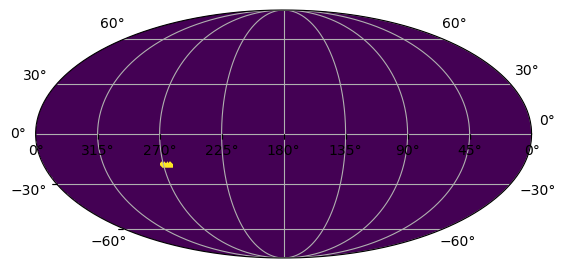

In [9]:
ax = plt.axes(projection='astro degrees mollweide')
ax.imshow_hpx(m)
ax.grid()

In [10]:
myInfoDict = {'MOC': True,
 'HISTORY': ['','the 3I/ATLAS region',''],
 'objid': '3I/ATLAS',
 'url': 'https://science.nasa.gov/solar-system/comets/3i-atlas/',
 'instruments': {'We are Rubin'},
 'gps_time': np.float64(1427175645.393101),
 'gps_creation_time': np.float64(1427175737.0),
 'creator': 'SeanMacBride',
 'origin': 'Interstellar space',
 'runtime': 0.8840621821582317,
 'distmean': 492.3283226737386,
 'diststd': 90.58048562217944,
 'log_bci': 16.912239046721254,
 'log_bsn': 206.5341106566025,
 'vcs_version': 'ligo.skymap 2.1.2',
 'nest': True}

In [12]:
write_sky_map("3I_ATLAS_skymap.fits.fz",m,**myInfoDict)

In [39]:
m = HealpixMap.read_map("3I_ATLAS_skymap.fits.fz")

In [40]:
mm = m.to_moc(max(m))

In [41]:
print("Is multi-resolution? {}".format(True if mm.is_moc else False))
print("nside: {}".format(mm.nside))
print("# of pixels: {}".format(mm.npix))

Is multi-resolution? True
nside: 2048
# of pixels: 49401


In [49]:
mm.write_map("3I_ATLAS_skymap.multiorder.fits.fz",overwrite=True)

In [53]:
# mm.read_map("3I_ATLAS_skymap.multiorder.fits.fz")
hmap = HealpixMap.read_map("3I_ATLAS_skymap.multiorder.fits.fz")

In [90]:
byteMap = healpix_map_to_base64(hmap)

In [121]:
base64_to_healpix_map(byteMap)

## Now write this to the avro for submission to the ToO system

In [107]:
reader = avro.datafile.DataFileReader(open('/Users/sean/Downloads/S250328ae-initial.avro',"rb"),avro.io.DatumReader())
schema = reader.meta

In [95]:
schema['avro.schema']

b'{"type": "record", "doc": "Alert schema v1.0.", "name": "igwn.alerts.v1_0.Alert", "fields": [{"doc": "The type of alert; the possible values are EARLY_WARNING, PRELIMINARY, INITIAL, UPDATE, RETRACTION.", "name": "alert_type", "type": {"type": "enum", "doc": "The type of alert.", "name": "igwn.alerts.v1_0.AlertType", "symbols": ["EARLYWARNING", "PRELIMINARY", "INITIAL", "UPDATE", "RETRACTION"]}}, {"doc": "The time this notice was created in ISO 8601 format.", "name": "time_created", "type": "string"}, {"doc": "The GraceDB superevent ID.", "name": "superevent_id", "type": "string"}, {"doc": "Information about the event, if any.", "name": "event", "type": ["null", {"type": "record", "doc": "Information about the event.", "name": "igwn.alerts.v1_0.EventInfo", "fields": [{"doc": "Time of the event in ISO 8601 format.", "name": "time", "type": "string"}, {"doc": "False alarm rate of the event in Hz.", "name": "far", "type": "double"}, {"doc": "True for significant alerts.", "name": "signif

In [110]:
a['event']['skymap'] = byteMap
a["superevent_id"] = "BrandNewTest0"

In [123]:
writer = DataFileWriter(open("testAv.avro", "wb"), DatumWriter(), schema)
writer.close()